In [2]:
import gymnasium as gym

In [3]:
import time

In [4]:
env = gym.make('CartPole-v1', render_mode='human')

observation, info = env.reset()

print(observation)

total_reward = 0

end_episode = False
while not end_episode:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    print(observation)
    end_episode = terminated or truncated

env.reset()

env.close()

c:\Users\Broni\miniconda3\envs\rl_testing\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


[ 0.03692843  0.02126021  0.01309791 -0.03825963]
[ 0.03735364 -0.1740471   0.01233272  0.25852686]
[ 0.0338727   0.02089664  0.01750326 -0.03024077]
[ 0.03429063  0.21576327  0.01689844 -0.31735024]
[ 0.03860589  0.02040475  0.01055144 -0.0193864 ]
[ 0.03901399 -0.17486691  0.01016371  0.27660686]
[ 0.03551665  0.02010857  0.01569585 -0.01285318]
[ 0.03591882  0.21500194  0.01543879 -0.30054283]
[ 0.04021886  0.4099005   0.00942793 -0.588317  ]
[ 0.04841687  0.21464777 -0.00233841 -0.2926792 ]
[ 0.05270983  0.01955925 -0.00819199 -0.00073467]
[ 0.05310101  0.21479772 -0.00820669 -0.29599097]
[ 0.05739697  0.01979372 -0.01412651 -0.00590756]
[ 0.05779284  0.21511538 -0.01424466 -0.3030139 ]
[ 0.06209515  0.02019931 -0.02030494 -0.01485722]
[ 0.06249914 -0.17462565 -0.02060208  0.27135074]
[ 0.05900662 -0.36944765 -0.01517507  0.55746514]
[ 0.05161767 -0.5643533  -0.00402576  0.8453287 ]
[ 0.0403306  -0.7594201   0.01288081  1.136743  ]
[ 0.0251422  -0.95470816  0.03561567  1.4334376 ]


In [5]:
env = gym.make('CarRacing-v3')
print(env.observation_space)

Box(0, 255, (96, 96, 3), uint8)


In [6]:
from gymnasium.wrappers import FlattenObservation

flat_env = FlattenObservation(env)
print(flat_env.observation_space)

Box(0, 255, (27648,), uint8)


# Q-Learning on BlackJack

In [90]:
from collections import defaultdict
import numpy as np
from random import random
from tqdm import tqdm

In [188]:
class BlackJackAgent():

    def __init__(self, env, lr, eps_init, eps_decay, eps_final, gamma):

        self.env = env
        self.lr = lr
        self.eps_init = eps_init
        self.eps_decay = eps_decay
        self.eps_final = eps_final
        self.epsilon = eps_init
        self.gamma = gamma

        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))

        self.training_error = []

    def get_action(self, state):

        if random() < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = int(np.argmax(self.q_table[state]))
        return action

    def update(self, state, reward, action, next_state, terminated):

        temporal_difference = reward + self.gamma*(not terminated)*np.max(self.q_table[next_state]) - self.q_table[state][action]
        self.q_table[state][action] += self.lr*temporal_difference

        self.training_error.append(temporal_difference)

    def decay_epsilon(self):

        self.epsilon = max(self.eps_final, self.epsilon-self.eps_decay)


Training Loop : 

In [276]:
nb_episodes = 3*int(1e5)
lr = 0.01

eps_init = 1.0
eps_decay = 2*eps_init/nb_episodes
eps_final = 0.1
gamma = 0.95

env = gym.make('Blackjack-v1', sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=nb_episodes)

agent = BlackJackAgent(env, lr, eps_init, eps_decay, eps_final, gamma)
print(agent.training_error)

for i in tqdm(range(nb_episodes)):
    state, info = env.reset()

    episode_finished = False

    while not episode_finished:

        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = agent.env.step(action)
        agent.update(state, reward, action, next_state, terminated)
        episode_finished = terminated or truncated
        state = next_state

    agent.decay_epsilon()


[]


100%|██████████| 300000/300000 [00:31<00:00, 9462.43it/s]


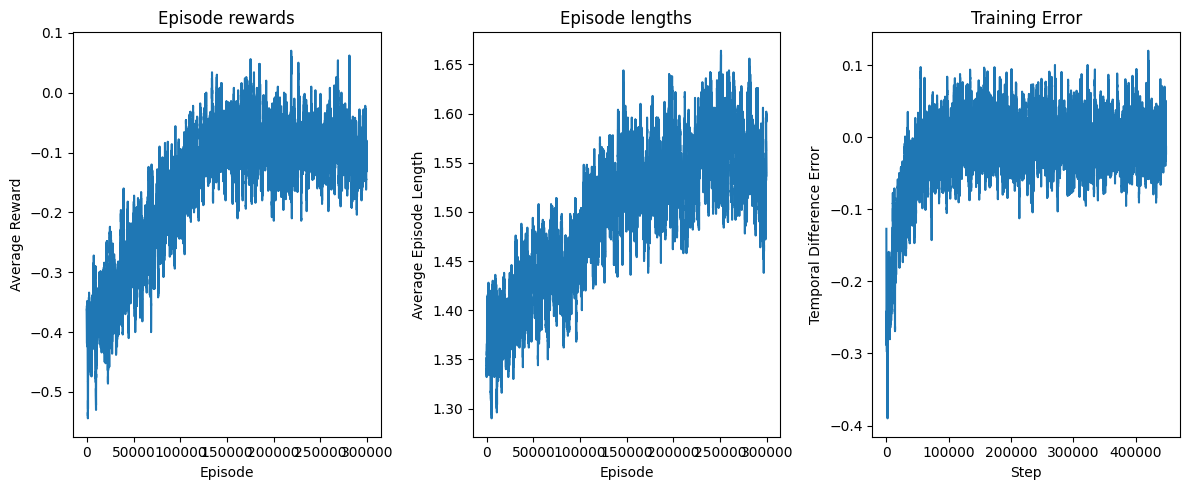

In [277]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()

In [285]:
# Test the trained agent
def test_agent(agent, env, num_episodes=1000):
    """Test agent performance without learning or exploration."""
    total_rewards = []

    # Temporarily disable exploration for testing
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # Pure exploitation

    for _ in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated

        total_rewards.append(episode_reward)

    # Restore original epsilon
    agent.epsilon = old_epsilon

    win_rate = np.mean(np.array(total_rewards) > 0)
    average_reward = np.mean(total_rewards)

    print(f"Test Results over {num_episodes} episodes:")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average Reward: {average_reward:.3f}")
    print(f"Standard Deviation: {np.std(total_rewards):.3f}")

# Test your agent
test_agent(agent, env)

Test Results over 1000 episodes:
Win Rate: 43.5%
Average Reward: -0.042
Standard Deviation: 0.954


win rate is typically around 43% which is not the theorical maximum of 49%